In [14]:
#https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html#sphx-glr-auto-examples-applications-plot-cyclical-feature-engineering-py

from sklearn.datasets import fetch_openml
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate
from sklearn.linear_model import RidgeCV

bike_sharing = fetch_openml("Bike_Sharing_Demand", version=2, as_frame=True)
df = bike_sharing.frame

X = df.drop("count", axis="columns")
y = df["count"] / df["count"].max()

from sklearn.model_selection import TimeSeriesSplit
ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=48,
    max_train_size=10000,
    test_size=1000,
)

all_splits = list(ts_cv.split(X, y))
train_0, test_0 = all_splits[0]

#Trigonometric features
from sklearn.preprocessing import FunctionTransformer

def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )

one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
alphas = np.logspace(-6, 6, 25)

#ColumnTransformer
categorical_columns = [
    "weather",
    "season",
    "holiday",
    "workingday",
]

cyclic_cossin_transformer = ColumnTransformer(
    transformers=[
        ("categorical", one_hot_encoder, categorical_columns),
        ("month_sin", sin_transformer(12), ["month"]),
        ("month_cos", cos_transformer(12), ["month"]),
        ("weekday_sin", sin_transformer(7), ["weekday"]),
        ("weekday_cos", cos_transformer(7), ["weekday"]),
        ("hour_sin", sin_transformer(24), ["hour"]),
        ("hour_cos", cos_transformer(24), ["hour"]),
    ],
    remainder=MinMaxScaler(),
)
cyclic_cossin_linear_pipeline = make_pipeline(
    cyclic_cossin_transformer,
    RidgeCV(alphas=alphas),
)
evaluate(cyclic_cossin_linear_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     0.125 +/- 0.014
Root Mean Squared Error: 0.166 +/- 0.020


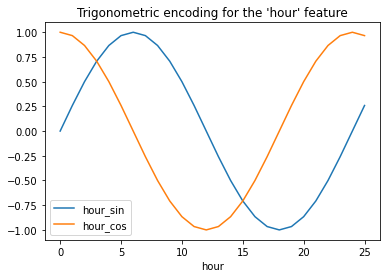

In [5]:
#https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html#sphx-glr-auto-examples-applications-plot-cyclical-feature-engineering-py

#Trigonometric features


from sklearn.preprocessing import FunctionTransformer

def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

hour_df = pd.DataFrame(
    np.arange(26).reshape(-1, 1),
    columns=["hour"],
)

hour_df

hour_df["hour_sin"] = sin_transformer(24).fit_transform(hour_df)["hour"]
hour_df["hour_cos"] = cos_transformer(24).fit_transform(hour_df)["hour"]
hour_df.plot(x="hour")
_ = plt.title("Trigonometric encoding for the 'hour' feature")

In [ ]:
#https://www.analyticsvidhya.com/blog/2022/06/time-series-forecasting-using-python/

train_original=train.copy()
test_original=test.copy()
train['Datetime'] = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M')
for i in (train, test, test_original, train_original):
    i['year']=i.Datetime.dt.year 
    i['month']=i.Datetime.dt.month 
    i['day']=i.Datetime.dt.day    

#extract the day of the week from Datetime
#assign 1 if the day of the week is a weekend and 0 if the day of the week in not a weekend.

def applyer(row):
    if row.dayofweek == 5 or row.dayofweek == 6:
        return 1
    else:
        return 0
temp2 = train['Datetime'].apply(applyer) 
train['weekend']=temp2

#EDA
train.groupby('year')['Count'].mean().plot.bar()
train.groupby('month')['Count'].mean().plot.bar()
temp=train.groupby(['year', 'month'])['Count'].mean() 
temp.plot(figsize=(15,5), title= 'Passenger Count(Monthwise)', fontsize=14)
train.groupby('day')['Count'].mean().plot.bar()
train.groupby('Hour')['Count'].mean().plot.bar()
train.groupby('weekend')['Count'].mean().plot.bar()
train.groupby('day of week')['Count'].mean().plot.bar()

#As we have seen that there is a lot of noise in the hourly time series, we will aggregate the hourly time series into daily, weekly, and monthly time #series to reduce the noise and make it more stable and hence would be easier for a model to learn.

train.Timestamp = pd.to_datetime(train.Datetime, format='%d-%m-%Y %H:%M') 
train.index = train.Timestamp 
hourly = train.resample('H').mean() 
daily = train.resample('D').mean() 
weekly = train.resample('W').mean() 
monthly = train.resample('M').mean()

#Let’s look at the hourly, daily, weekly, and monthly time series.
fig, axs = plt.subplots(4,1) 
hourly.Count.plot(figsize=(15,8), title= 'Hourly', fontsize=14, ax=axs[0])
daily.Count.plot(figsize=(15,8), title= 'Daily', fontsize=14, ax=axs[1])
weekly.Count.plot(figsize=(15,8), title= 'Weekly', fontsize=14, ax=axs[2]) 
monthly.Count.plot(figsize=(15,8), title= 'Monthly', fontsize=14, ax=axs[3]) 
plt.show()

#it would be difficult to convert the monthly and weekly predictions to hourly predictions, as first we have to convert the monthly predictions to #weekly, weekly to daily, and daily to hourly predictions, which will become a very expanded process. So, we will work on the daily time series.
test.Timestamp = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M') 
test.index = test.Timestamp 
test = test.resample('D').mean() 
train.Timestamp = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M')
 train.index = train.Timestamp  
train = train.resample('D').mean()

#Modeling Techniques and Evaluation
#1) Splitting the data into the training and validation part
Train=train.ix['2012-08-25':'2014-06-24'] valid=train.ix['2014-06-25':'2014-09-25']

Train.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14, label='train') 
valid.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14, label='valid') 
plt.xlabel("Datetime") plt.ylabel("Passenger count") 
plt.legend(loc='best') plt.show()

#models for Time Series Forecasting.

# Naive Approach - next expected point is equal to the last observed point
dd= np.asarray(Train.Count) 
y_hat = valid.copy() 
y_hat['naive'] = dd[len(dd)-1] 
plt.figure(figsize=(12,8)) 
plt.plot(Train.index, Train['Count'], label='Train') 
plt.plot(valid.index,valid['Count'], label='Valid') 
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast') 
plt.legend(loc='best') 
plt.title("Naive Forecast") 
plt.show()

from sklearn.metrics import mean_squared_error 
from math import sqrt 
rms = sqrt(mean_squared_error(valid.Count, y_hat.naive)) 
print(rms)

# Moving Average - take the average of the passenger counts for the last few time periods only
#rolling mean for the last 10, 20, and 50 days and visualize the results.

y_hat_avg = valid.copy() 
y_hat_avg['moving_avg_forecast'] = Train['Count'].rolling(10).mean().iloc[-1] 
#y_hat_avg['moving_avg_forecast'] = Train['Count'].rolling(20).mean().iloc[-1] 
#y_hat_avg['moving_avg_forecast'] = Train['Count'].rolling(50).mean().iloc[-1] 
plt.figure(figsize=(15,5)) 
plt.plot(Train['Count'], label='Train') 
plt.plot(valid['Count'], label='Valid') 
plt.plot(y_hat_avg['moving_avg_forecast'], 
                label='Moving Average Forecast using 10 observations')
plt.legend(loc='best') 
plt.show()

rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.moving_avg_forecast)) 
print(rms)

# Simple Exponential Smoothing - we assign larger weights to more recent observations than to observations from the distant past.
#The weights decrease exponentially as observations come from further in the past, the smallest weights are associated with the oldest observations.
from statsmodels.tsa.api 
import ExponentialSmoothing, SimpleExpSmoothing, Holt 
y_hat_avg = valid.copy() 
fit2 = SimpleExpSmoothing(np.asarray(Train['Count'])).fit(smoothing_level=0.6,
        optimized=False) y_hat_avg['SES'] = fit2.forecast(len(valid))
plt.figure(figsize=(16,8))  
plt.plot(Train['Count'], label='Train') 
plt.plot(valid['Count'], label='Valid') 
plt.plot(y_hat_avg['SES'], label='SES') 
plt.legend(loc='best') 
plt.show()

rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.SES)) 
print(rms)

# Holt’s Linear Trend Model - It is an extension of simple exponential smoothing to allow forecasting of data with a trend.
import statsmodels.api as sm 
sm.tsa.seasonal_decompose(Train.Count).plot() 
result = sm.tsa.stattools.adfuller(train.Count) 
plt.show()

y_hat_avg = valid.copy() 
fit1 = Holt(np.asarray(Train['Count'])).fit(smoothing_level = 0.3,
        smoothing_slope = 0.1) y_hat_avg['Holt_linear'] = fit1.forecast(len(valid)) 
plt.figure(figsize=(16,8))
plt.plot(Train['Count'], label='Train')
plt.plot(valid['Count'], label='Valid') 
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear') 
plt.legend(loc='best') 
plt.show()

rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.Holt_linear)) 
print(rms)

730
           Births
count  365.000000
mean    41.980822
std      7.348257
min     23.000000
25%     37.000000
50%     42.000000
75%     46.000000
max     73.000000


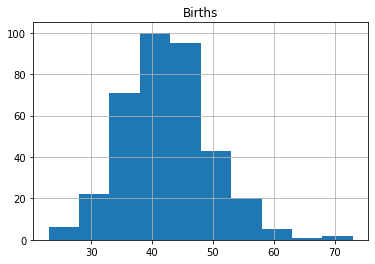

ValueError: cannot reshape array of size 730 into shape (365,1)

In [8]:
#https://www.analyticsvidhya.com/blog/2022/05/a-comprehensive-guide-to-time-series-analysis-and-forecasting/ 5*

import numpy as np
import pandas as pd
#import statmodels
import matplotlib.pyplot as plt
import seaborn as sns

data_path = 'D:\\timeseries\\testing_data\\'
data = pd.read_csv(data_path+'daily-total-female-births-in-cal.csv', parse_dates = True, header = 0, squeeze=True)


print(data.size) #output-365
print(data.describe())

data.head()
data.hist()
plt.show()

# plt.plot(data)
# plt.show()

#Scale and Normalize Time Series Data for Further Modelling
#convert data into matrix of row-col vectors
values = data.values
values = values.reshape((len(values), 1))
# feature scaling
scaler = MinMaxScaler(feature_range=(0, 1))
#fit the scaler with the train data to get min-max values
scaler = scalar.fit(values)
print('Min: %f, Max: %f' % (scaler.data_min_, scaler.data_max_))
# normalize the data and sanity check
normalized = scaler.transform(values)
for i in range(5):
    print(normalized[i])
# inverse transform to obtain original values
original_matrix= scaler.inverse_transform(normalized)
for i in range(5):
    print(original_matrix[i])

#Extracting Useful Features from Time-Series Data (Feature Engineering)
from pandas import DataFrame
from pandas import concat
df = DataFrame(data.values)
tshifts = df.shift(1)
rwin = tshifts.rolling(window=2)
moving_avg = rwin.mean()
joined_df = concat([moving_avg, df], axis=1)
joined_df.columns = ['mean(t-2,t-1)', 't+1']
print(joined_df.head(5))

#Expanding Window Statistics
window = tshifts.expanding()
joined_df2 = concat([rwin.mean(),df.shift(-1)], axis=1)
joined_df2.columns = ['mean', 't+1']
print(joined_df2.head(5))

#Time-series Data Stationary Checks
X = data.values
seq = round(len(X) / 2)
x1, x2 = X[0:seq], X[seq:]
meanx1, meanx2 = x1.mean(), x2.mean()
varx1, varx2 = x1.var(), x2.var()
print('meanx1=%f, meanx2=%f' % (meanx1, meanx2))
print('variancex1=%f, variancex2=%f' % (varx1, varx2))

#ARMA, ARIMA, and SARIMAX Models for Time-Series Forecasting

#1 AR model
AR_model = ARIMA(indexedDataset_logScale, order=(2,1,0))
AR_results = AR_model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(AR_results.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((AR_results.fittedvalues - datasetLogDiffShifting['#Passengers'])**2))

#2MA Model
MA_model = ARIMA(indexedDataset_logScale, order=(0,1,2))
MA_results = MA_model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(MA_results.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((MA_results.fittedvalues - datasetLogDiffShifting['#Passengers'])**2))

#3ARIMA
ARIMA_model = ARIMA(indexedDataset_logScale, order=(2,1,2))
ARIMA_results = ARIMA_model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(ARIMA_results.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((ARIMA_results.fittedvalues - datasetLogDiffShifting['#Passengers'])**2))

#4 SARIMAX
'''
1. Seasonal Autoregressive Component
2. Seasonal Moving Average Component
3. Seasonal Integrity Order Component
4. Seasonal Periodicity
'''
from statsmodels.tsa.statespace.sarimax import SARIMAX
SARIMAX_model=SARIMAX(train['#Passengers'],order=(1,1,1),seasonal_order=(1,0,0,12))
SARIMAX_results=SARIMAX_model.fit()
preds=SARIMAX_results.predict(start,end,typ='levels').rename('SARIMAX Predictions')
test['#Passengers'].plot(legend=True,figsize=(8,5))
preds.plot(legend=True)

#5 NN Models
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score
from keras.layers import Dense, Dropout, SimpleRNN, LSTM
from keras.models import Sequential

minmax_scaler = sklearn.preprocessing.MinMaxScaler()
data['Passengers'] = minmax_scaler.fit_transform(data['Passengers'].values.reshape(-1,1))
data.head()

#Train, test splits (80–20 ratio) — 
split = int(len(data[‘Passengers’])*0.8)
x_train,y_train,x_test,y_test = np.array(x[:split]),np.array(y[:split]),
np.array(x[split:]), np.array(y[split:])
#reshaping data to original shape
x_train = np.reshape(x_train, (split, 20, 1))
x_test = np.reshape(x_test, (x_test.shape[0], 20, 1))

#5.1 RNN Model — 
model = Sequential()
model.add(SimpleRNN(40, activation="tanh", return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.15))
model.add(SimpleRNN(50, return_sequences=True, activation="tanh"))
model.add(Dropout(0.1)) #remove overfitting
model.add(SimpleRNN(10, activation="tanh"))
model.add(Dense(1))
model.summary()

model.compile(optimizer="adam", loss="MSE")
model.fit(x_train, y_train, epochs=15, batch_size=50)
preds = model.predict(x_test)

# 5.2 LSTM Model — 
model = Sequential()
model.add(LSTM(100, activation="ReLU", return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(80, activation="ReLU", return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, activation="ReLU", return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(30, activation="ReLU"))
model.add(Dense(1))
model.summary()

model.compile(optimizer="adam", loss="MSE")
model.fit(x_train, y_train, epochs=15, batch_size=50)
preds = model.predict(x_test)



In [ ]:
#smoothing Technique
# https://medium.com/@srv96/smoothing-techniques-for-time-series-data-91cccfd008a2#id_token=eyJhbGciOiJSUzI1NiIsImtpZCI6Ijg2MTY0OWU0NTAzMTUzODNmNmI5ZDUxMGI3Y2Q0ZTkyMjZjM2NkODgiLCJ0eXAiOiJKV1QifQ.eyJpc3MiOiJodHRwczovL2FjY291bnRzLmdvb2dsZS5jb20iLCJuYmYiOjE2NTEwNTIzODcsImF1ZCI6IjIxNjI5NjAzNTgzNC1rMWs2cWUwNjBzMnRwMmEyamFtNGxqZGNtczAwc3R0Zy5hcHBzLmdvb2dsZXVzZXJjb250ZW50LmNvbSIsInN1YiI6IjExMzg1MTA1MzE4MzkyMTM3MTMzMyIsImVtYWlsIjoiYWpheXZlcm1hMjNAZ21haWwuY29tIiwiZW1haWxfdmVyaWZpZWQiOnRydWUsImF6cCI6IjIxNjI5NjAzNTgzNC1rMWs2cWUwNjBzMnRwMmEyamFtNGxqZGNtczAwc3R0Zy5hcHBzLmdvb2dsZXVzZXJjb250ZW50LmNvbSIsIm5hbWUiOiJBamF5IFZlcm1hIiwicGljdHVyZSI6Imh0dHBzOi8vbGgzLmdvb2dsZXVzZXJjb250ZW50LmNvbS9hLS9BT2gxNEdoWDVTS1poYTNIc2ppMkxGRXotcXgwQVh5amw5Wm9kcGowUjNCSkxBPXM5Ni1jIiwiZ2l2ZW5fbmFtZSI6IkFqYXkiLCJmYW1pbHlfbmFtZSI6IlZlcm1hIiwiaWF0IjoxNjUxMDUyNjg3LCJleHAiOjE2NTEwNTYyODcsImp0aSI6IjkwZTE2YzgyMTg1YzJjMDUxM2RlNzQ1ZjlmOGM0MmViNmViODNkNTUifQ.SVWUtkftoOT4qlHenzcf2oWG1N2Os7nhDCcL5xgBKw9jDTOnN6jRWVzVY0gbffbGR1n16OIFVUQ9Ra4Dg-H3Ef72V9n8_QpvtQ4HvrGFYmFNGd5xiAusoHaoqISNhLtX5f2SRFaXMFqgqTfXChXm4_cWLDVBy2MbjAi7kI1sWGnuz7zGgK-VIlcyoUlhh5QdX3AG7rRHJk388Xorwd5IPfyGCrq1tTb1cz3ybwU32xPr1K2y7beUhEcbD--IHISH5VItSzRnygVxMMEGyW47wQma5AeeEiUONk3M-V77iCySQlqV0aO5_a4G68rTKvJcbGS5y788xFf9azRFbaWIEA
def moving_avarage_smoothing(X,k):
	S = np.zeros(X.shape[0])
	for t in range(X.shape[0]):
		if t < k:
			S[t] = np.mean(X[:t+1])
		else:
			S[t] = np.sum(X[t-k:t])/k
	return S

def double_exponential_smoothing(X,α,β):
	S,A,B = (np.zeros( X.shape[0] ) for i in range(3))
	S[0] = X[0]
	B[0] = X[1] - X[0]
	for t in range(1,X.shape[0]):
		A[t] = α * X[t] + (1- α) * S[t-1]
		B[t] = β * (A[t] - A[t-1]) + (1 - β) * B[t-1]
		S[t] = A[t] + B[t]
	return S

def triple_exponential_smoothing(X,L,α,β,γ,ϕ):

	def sig_ϕ(ϕ,m):
		return np.sum(np.array([np.power(ϕ,i) for i in range(m+1)]))

	C, S, B, F = (np.zeros( X.shape[0] ) for i in range(4))
	S[0], F[0] = X[0], X[0]
	B[0] = np.mean( X[L:2*L] - X[:L] ) / L
	m = 12
	sig_ϕ = sig_ϕ(ϕ,m)
	for t in range(1, X.shape[0]):
		S[t] = α * (X[t] - C[t % L]) + (1 - α) * (S[t-1] + ϕ * B[t-1])
		B[t] = β * (S[t] - S[t-1]) + (1-β) * ϕ * B[t-1]
		C[t % L] = γ * (X[t] - S[t]) + (1 - γ) * C[t % L]
		F[t] = S[t] + sig_ϕ * B[t] + C[t % L]
	return S



In [8]:
#https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_process.ArmaProcess.html
# TS Synthetic Data

import pandas as pd
'''
arroots: Roots of autoregressive lag-polynomial
isinvertible: Arma process is invertible if MA roots are outside unit circle.
isstationary: Arma process is stationary if AR roots are outside unit circle.
maroots: Roots of moving average lag-polynomial

'''
import statsmodels.api as sm
import numpy as np
np.random.seed(12345)
arparams = np.array([.75, -.25])
maparams = np.array([.65, .35])
ar = np.r_[1, -arparams] # add zero-lag and negate
ma = np.r_[1, maparams] # add zero-lag
arma_process = sm.tsa.ArmaProcess(ar, ma)
print(f'isstationary:{arma_process.isstationary}, isinvertible:{arma_process.isinvertible}, arroots:{arma_process.arroots}')
y = arma_process.generate_sample(250)
#model = sm.tsa.ARIMA(y, (2, 0, 2), trend='n').fit(disp=0)
model = sm.tsa.ARIMA(y, (2, 0, 2)).fit(disp=0)
model.params


#https://medium.com/wwblog/time-series-clustering-based-on-autocorrelation-using-python-94d5e3475179

processes = [
    arma_process.from_coeffs([], []),       # White noise
    arma_process.from_coeffs([-0.5], []),   # AR(1) 
    arma_process.from_coeffs([], [0.9]),    # MA(1)
    arma_process.from_coeffs([0.5], [0.5])  # ARMA(1, 1)
]

# Number of time series per process
series_per_process = 3
# Length of an individual time series
T = 1_000
n_processes = len(processes)
n_series = n_processes * series_per_process
# Generate the time series.
df = pd.DataFrame()
for i in range(n_series):
    df[f"TS_{i}"] = processes[i // series_per_process] \
        .generate_sample(T)
    
df.head()

isstationary:True, isinvertible:True, arroots:[1.5-1.32287566j 1.5+1.32287566j]


,TS_0,TS_1,TS_2,TS_3,TS_4,TS_5,TS_6,TS_7,TS_8,TS_9,TS_10,TS_11
0,1.394072,0.614350,0.341411,0.225611,0.236063,-0.708100,-0.300582,0.667089,0.304429,0.720835,0.796007,1.734534
1,-1.076742,0.427964,-0.316885,0.455849,-0.848778,-0.208401,-0.318657,0.225593,-1.234162,1.597803,-0.576539,1.972715
2,-0.192466,-0.271959,0.397511,-0.306026,0.031103,0.503261,1.589360,-0.678936,-1.544253,1.251726,-1.187012,2.497354
3,-0.871188,0.738759,0.048153,0.256468,-0.687391,0.468587,1.249167,0.829319,1.570098,-0.040154,-1.664391,2.070954
4,0.420852,-0.508070,0.229769,0.161890,-0.081185,-1.227538,-0.094799,0.751147,-1.422480,-0.293196,-2.033684,0.107879


In [13]:
#https://medium.com/@edwinsutrisno/midimax-data-compression-for-large-time-series-data-daf744c89310

# -*- coding: utf-8 -*-
"""
Midimax Data Compression for Time-Series
Author: Edwin Sutrisno
Changes:
    April 16, 2022: First version (Edwin Sutrisno).
"""

import pandas as pd


def compress_series(inputser: pd.Series, compfactor=2):
    """
    Split into segments and pick 3 points from each segment, the minimum,
    median, and maximum. Segment length = int(compfactor x 3). So, to achieve a
    compression factor of 2, a segment length of 6 is needed.
    Parameters
    ----------
    inputser : pd.Series
        Input data to be compressed.
    compfactor : float
        Compression factor. The default is 2.
    Returns
    -------
    pd.Series
        Compressed output series.
    """
    # If comp factor is too low, return original data
    if (compfactor < 1.4):
        return inputser

    win_size = int(3 * compfactor)  # window size

    # Create a column ofsegment numbers
    ser = inputser.rename('value')
    ser = ser.round(3)
    wdf = ser.to_frame()
    del ser
    start_idxs = wdf.index[range(0, len(wdf), win_size)]
    wdf['win_start'] = 0
    wdf.loc[start_idxs, 'win_start'] = 1
    wdf['win_num'] = wdf['win_start'].cumsum()
    wdf.drop(columns='win_start', inplace=True)
    del win_size, start_idxs

    # For each window, get the indices of min, median, and max
    def get_midimax_idxs(gdf):
        if len(gdf) == 1:
            return [gdf.index[0]]
        elif gdf['value'].iloc[0] == gdf['value'].iloc[-1]:
            return [gdf.index[0]]
        elif len(gdf) == 2:
            return [gdf.index[0], gdf.index[1]]
        else:
            return [gdf.index[0], gdf.index[len(gdf) // 2], gdf.index[-1]]

    wdf = wdf.dropna()
    wdf_sorted = wdf.sort_values(['win_num', 'value'])
    midimax_idxs = wdf_sorted.groupby('win_num').apply(get_midimax_idxs)

    # Convert into a list
    midimax_idxs = [idx for sublist in midimax_idxs for idx in sublist]
    midimax_idxs.sort()
    return inputser.loc[midimax_idxs]

import time
import numpy as np
import pandas as pd
n = 100000 # points
timesteps = pd.to_timedelta(np.arange(n), unit='s')
#timestamps = pd.to_datetime('2022–04–18 08:00:00') + timesteps
#pd.to_datetime(['2018-10-26 12:00 -0530', '2018-10-26 12:00 -0500'])
timestamps = pd.to_datetime('2022-04-18 12:00 -0530') + timesteps

sine_waves = np.sin(2 * np.pi * 0.02 * np.arange(n))
noise = np.random.normal(0, 0.1, n)
signal = sine_waves + noise
ts_data = pd.Series(signal, index=timestamps).astype('float32')

ts_data

# Run compression
timer_start = time.time()
ts_data_compressed = compress_series(ts_data, 2)
timer_sec = round(time.time() - timer_start, 2)
print('Compression took', timer_sec, 'seconds.')

ts_data_compressed

Compression took 3.2 seconds.


2022-04-18 12:00:01-05:30    0.038616
2022-04-18 12:00:03-05:30    0.547338
2022-04-18 12:00:04-05:30    0.449986
2022-04-18 12:00:08-05:30    0.587789
2022-04-18 12:00:10-05:30    1.028504
                               ...   
2022-04-19 15:46:31-05:30   -0.740375
2022-04-19 15:46:34-05:30   -0.626330
2022-04-19 15:46:36-05:30   -0.422997
2022-04-19 15:46:37-05:30   -0.205155
2022-04-19 15:46:39-05:30   -0.085990
Length: 50001, dtype: float32

In [31]:
#https://medium.com/@jedrzejalchimowicz/tackle-time-series-forecasting-with-supervised-machine-learning-a-step-by-step-guide-in-python-a5510063f8c9

import pandas as pd
# Create DataFrame
data = {'cust_id': [1]*3 + [2]*3,
        'x1': [1,2,3,4,5,6],
        'x2': ['green', 'blue', 'blue', 'green', 'blue', 'yellow'],
        'x3': [10,15,12,19,21,13],
        'date': pd.date_range('3/1/2020', '3/3/2020').tolist()*2,
        'y': [0,1,0,0,1,0]}
df = pd.DataFrame(data)

#convert catg var to numeric
# Create a table with encoded variable
one_hot_x2 = pd.get_dummies(df['x2'], prefix='x2')

# Join the newly created table with the original one
df = pd.merge(df, one_hot_x2, left_index=True, right_index=True).drop(columns=['x2'])

# Declare output dataframe
df_new = pd.DataFrame()

for customer in df['cust_id'].unique():
  
    # Get the part of df refering to one customer
    df_temp = df[df['cust_id'] == customer]
    
    # Shift the dependent variable one period up
    df_temp['adapted_y'] = df_temp['y'].shift(-1)
    
    # Create new variables from num variable
    df_temp['x2_avg_2periods'] = df_temp['x1'].rolling(2, min_periods=1).mean()
    df_temp['x2_max_2periods'] = df_temp['x1'].rolling(2, min_periods=1).max()
    
    # Create new variables from cat variable
    df_temp['x2_green_sum_3periods']  = df_temp['x2_green'].rolling(2, min_periods=1).sum()
    df_temp['x2_blue_sum_3periods']   = df_temp['x2_blue'].rolling(2, min_periods=1).sum()
    df_temp['x2_yellow_sum_3periods'] = df_temp['x2_yellow'].rolling(2, min_periods=1).sum()
    
    # Add the customer to the output table
    df_new = df_new.append(df_temp)
    
df_new

C:\Users\ajverma\AppData\Local\Temp/ipykernel_13532/2184144846.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['adapted_y'] = df_temp['y'].shift(-1)
C:\Users\ajverma\AppData\Local\Temp/ipykernel_13532/2184144846.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['x2_avg_2periods'] = df_temp['x1'].rolling(2, min_periods=1).mean()
C:\Users\ajverma\AppData\Local\Temp/ipykernel_13532/2184144846.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

,cust_id,x1,x3,date,y,x2_blue,x2_green,x2_yellow,adapted_y,x2_avg_2periods,x2_max_2periods,x2_green_sum_3periods,x2_blue_sum_3periods,x2_yellow_sum_3periods
0,1,1,10,2020-03-01,0,0,1,0,1.0,1.0,1.0,1.0,0.0,0.0
1,1,2,15,2020-03-02,1,1,0,0,0.0,1.5,2.0,1.0,1.0,0.0
2,1,3,12,2020-03-03,0,1,0,0,NaN,2.5,3.0,0.0,2.0,0.0
3,2,4,19,2020-03-01,0,0,1,0,1.0,4.0,4.0,1.0,0.0,0.0
4,2,5,21,2020-03-02,1,1,0,0,0.0,4.5,5.0,1.0,1.0,0.0
5,2,6,13,2020-03-03,0,0,0,1,NaN,5.5,6.0,0.0,1.0,1.0


In [24]:
df

,cust_id,x1,x2,x3,date,y
0,1,1,10,green,2020-03-01,0
1,1,2,15,blue,2020-03-02,1
2,1,3,12,blue,2020-03-03,0
3,2,4,19,green,2020-03-01,0
4,2,5,21,blue,2020-03-02,1
5,2,6,13,green,2020-03-03,0


In [20]:
#https://towardsdatascience.com/an-introduction-to-exceedance-probability-forecasting-4c96c0e7772c
#https://towardsdatascience.com/forecasting-with-trees-hybrid-classifiers-for-time-series-b2509abf15f8

#Exceedance probability forecasting - Binary Classification

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# reading the time series (pd.Series format)
#tseries = pd.read_csv('path_to_data.csv') 
# you can simulate some data with:
tseries = pd.Series(np.random.random(100))

# using 3 lags -- the no. of observation we look back to model the next value of the series
N_LAGS = 3
# Constructing a set of observations based on past recent values (lags)
tseries_df = pd.concat([tseries.shift(i) for i in range(N_LAGS, -1, -1)], axis=1)

# Assigning column names and dropping na's
tseries_df.columns = ['t-' + str(i) for i in list(reversed(range(N_LAGS)))] + ['t+1']
tseries_df = tseries_df.dropna().reset_index(drop=True)

# the target variable is the column 't+1' representing the next value of the series
y = tseries_df['t+1']
# Removing the target to create the predictor variables
X = tseries_df.drop('t+1', axis=1)

# basic train/test split -- you may want a more robust cross-validation approach
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=False)

# setting the threshold to the 95th percentile
thr = np.quantile(y_train, .95)

# transforming the numeric target to a binary one 
y_train_binary = (y_train >= thr).astype(int)
y_test_binary = (y_test >= thr).astype(int)

# training a probabilistic classifier
classifier = LogisticRegression()
classifier.fit(X_train, y_train_binary)

# predicting exceedance probability
exceedance_prob_clf = classifier.predict_proba(X_test)[:, 1]

#The alternative to a classification approach is to use a forecasting ensemble.
# Using the RF as ensemble of trees
from sklearn.ensemble import RandomForestRegressor

# Training the model
forecasting_ensemble = RandomForestRegressor()
# Here we use the numerical target
## which represents the next value of the time series
forecasting_ensemble.fit(X_train, y_train)

# Retrieving the predictions from the trees.
per_tree_pred = [tree.predict(X_test) for tree in forecasting_ensemble.estimators_]
per_tree_df = pd.DataFrame(per_tree_pred).T

# Computing the ratio of trees which predict a value above the threshold
exceedance_prob_fe = per_tree_df.apply(lambda x: np.mean(x > thr), axis=1).values

from sklearn.metrics import brier_score_loss, roc_auc_score

roc_auc_score(y_true=y_test_binary, y_score=exceedance_prob_fe)
roc_auc_score(y_true=y_test_binary, y_score=exceedance_prob_clf)

brier_score_loss(y_true=y_test_binary, y_prob=exceedance_prob_fe)
brier_score_loss(y_true=y_test_binary, y_prob=exceedance_prob_clf)

C:\Users\ajverma\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\ajverma\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\ajverma\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\ajverma\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\ajverma\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\ajverma\AppData\Roami

0.03149176513774439

In [ ]:
#https://www.kaggle.com/code/smeitoma/train-demo

'''Historical volatility
Next, we calculate the historical volatility. The historical volatility calculated here is the standard deviation of the
logarithmic price change over the last 10, 21, and 63 business days. Historical volatility is a risk indicator
and is used to determine how violently prices have fluctuated. In general, stocks with large historical volatility are
considered relatively riskier to hold as assets than stocks with small historical volatility.'''

periods = [10, 21, 63]
vol_names = []
for period in periods:
    vol_names.append(f"volatility_{period}")
    price.loc[:, f"volatility_{period}"] = np.log(price["AdjustedClose"]).diff().rolling(period).std()
    

# calculate 2 week return using AdjustedClose
feats["return_2week"] = feats[close_col].pct_change(10)
# calculate last 1 month return using AdjustedClose
feats["return_1month"] = feats[close_col].pct_change(21)
# calculate last 3 months return using AdjustedClose
feats["return_3month"] = feats[close_col].pct_change(63)

# calculate 2 week historical volatility using AdjustedClose
feats["volatility_2week"] = (np.log(feats[close_col]).diff().rolling(10).std())
# calculate last 1 month historical volatility using AdjustedClose
feats["volatility_1month"] = (np.log(feats[close_col]).diff().rolling(21).std())
# calculate last 3 months historical volatility using AdjustedClose
feats["volatility_3month"] = (np.log(feats[close_col]).diff().rolling(63).std())


# initialize model
pred_model = LGBMRegressor(**lgbm_params)
# train
pred_model.fit(train_X[feat_cols].values, train_y)
# prepare result data
result = test_X[["SecuritiesCode"]].copy()
# predict
result.loc[:, "predict"] = pred_model.predict(test_X[feat_cols])
# actual result
result.loc[:, "Target"] = test_y.values

In [ ]:
#https://www.kaggle.com/neomatrix369/everything-you-can-do-with-a-time-series-cryptos/notebook

#Forward filling missing data
data = data.iloc[1:]
data = data.fillna(method='ffill')

#Back filling missing data
data = data.fillna(method='bfill')

# downsample from hourly to 3 day frequency aggregated using mean
btc_resampled = btc.resample('3D').mean()

#upsample from 3 day frequency to daily frequency
btc_resampled = btc.resample('D').pad()

#Percent change plot
btc['Change'] = btc.High.div(btc.High.shift())
btc['Change'].plot(figsize=(20,8))
_ = plt.title('Change in High price of BTC over time')

btc['Volume_Change'] = btc.Volume.div(btc.Volume.shift())
btc['Volume_Change'].plot(figsize=(20,8))
_ = plt.title('Change in BTC Volume over time')

#Daily returns
btc['Return'] = btc.Change.sub(1).mul(100)
btc['Return'].plot(figsize=(20,8))
_ = plt.title('Return based on High price change of BTC over time')

btc.High.pct_change().mul(100).plot(figsize=(20,6)) # Another way to calculate returns
_ = plt.title('Percentage change of High price of BTC over time')

btc.Volume.pct_change().mul(100).plot(figsize=(20,6)) # Another way to calculate returns
_ = plt.title('Percentage change of BTC Volume over time')

#Absolute change in successive rows
btc.High.diff().plot(figsize=(20,6))
_ = plt.title('Difference in High price change of BTC over time')

#Comparing two or more time series
#We will compare 2 time series by normalizing them. This is achieved by dividing each time series element of all #time series by the first element. This way both series start at the same point and can be easily compared.

# Plotting before normalization
btc.High.plot()
eth.High.plot()
plt.legend(['BTC','ETH'])
_ = plt.title('Comparing BTC and ETH over time')
plt.show()

# Normalizing and comparison
# Both coins start from 100
normalized_btc = btc.High.div(btc.High.iloc[0]).mul(100)
normalized_eth = eth.High.div(eth.High.iloc[0]).mul(100)
normalized_btc.plot()
normalized_eth.plot()
_ = plt.title('Comparing BTC and ETH over time (normalized)')
plt.legend(['BTC','ETH'])
plt.show()

#Window functions
#Window functions are used to identify sub periods, calculates sub-metrics of sub-periods.
#Rolling - Same size and sliding
#Expanding - Contains all prior values

# Rolling window functions
rolling_btc = btc.High.rolling('90D').mean()
btc.High.plot()
rolling_btc.plot()
_ = plt.title('Comparing High price and rolling High price of BTC over time')
plt.legend(['High','Rolling Mean'])
# Plotting a rolling mean of 90 day window with original High attribute of BTC
plt.show()

# Expanding window functions
btc_mean = btc.High.expanding().mean()
btc_std = btc.High.expanding().std()
btc.High.plot()
btc_mean.plot()
btc_std.plot()
_ = plt.title('Comparing High price, Expanding Mean of High Price and Expanding Std. Dev. of High Price of BTC over time')
plt.legend(['High','Expanding Mean','Expanding Standard Deviation'])
plt.show()


#Open-high-low-close Charts (or OHLC Charts)
trace = go.Ohlc(x=btc['06-2021'].index,
                open=btc['06-2021'].Open,
                high=btc['06-2021'].High,
                low=btc['06-2021'].Low,
                close=btc['06-2021'].Close)
data = [trace]
print('OHLC price chart of BTC for June 2021')
iplot(data, filename='simple_ohlc')


# Candlestick chart of march 2008
trace = go.Candlestick(x=btc['06-2021'].index,
                open=btc['06-2021'].Open,
                high=btc['06-2021'].High,
                low=btc['06-2021'].Low,
                close=btc['06-2021'].Close)
data = [trace]
print('OHLC price chart (Candlestick) of BTC for June 2021')
iplot(data, filename='simple_candlestick')

# Autocorrelation of Closing price of BTC
#As all lags are either close to 1 or at least greater than the confidence interval, they are statistically significant.
plot_acf(btc["Close"],lags=25,title="Autocorrelation chart: BTC (Close price)")
plt.show()

# Partial Autocorrelation of Closing price of BTC
plot_pacf(btc["Close"],lags=25, title="Partial autocorrelation chart: BTC (Close price)")
plt.show()

#Time series decomposition and Random walks - Trends, seasonality and noise

# Let's take BTC's High for this
btc["High"].plot(figsize=(16,8))
_ = plt.title('Comparing High price of BTC over time')

# Now, for decomposition...
print('Decomposing closing price of BTC over time')
decomposed_btc_close = sm.tsa.seasonal_decompose(btc["Close"],freq=360) # The frequncy is annual
figure = decomposed_btc_close.plot()
plt.show()

# Plotting white noise
rcParams['figure.figsize'] = 16, 6
white_noise = np.random.normal(loc=0, scale=1, size=1000)
_ = plt.title('Generate Whitenoise')
# loc is mean, scale is variance
plt.plot(white_noise)

# Plotting autocorrelation of white noise
plot_acf(white_noise,lags=20)
plt.show()

# Augmented Dickey-Fuller test on volume of BTC and ETH coins 
adf = adfuller(btc["Volume"])
print("p-value of BTC: {}".format(float(adf[1])))
adf = adfuller(eth["Volume"])
print("p-value of ETH: {}".format(float(adf[1])))

seed(42)
rcParams['figure.figsize'] = 16, 6
random_walk = normal(loc=0, scale=0.01, size=1000)
_ = plt.title('Plot random walk')
plt.plot(random_walk)
plt.show()

#Stationarity
# The original non-stationary plot
decomposed_btc_close.trend.plot()
_ = plt.title('Decomposed BTC closing price over time')

# The original non-stationary plot
decomposed_btc_close.trend.diff().plot()
_ = plt.title('Decomposed BTC closing price difference over time')

# AR(1) MA(1) model:AR parameter = +0.9
rcParams['figure.figsize'] = 16, 12
plt.subplot(4,1,1)
ar1 = np.array([1, -0.9]) # We choose -0.9 as AR parameter is +0.9
ma1 = np.array([1])
AR1 = ArmaProcess(ar1, ma1)
sim1 = AR1.generate_sample(nsample=1000)
plt.title('AR(1) model: AR parameter = +0.9')
plt.plot(sim1)
# We will take care of MA model later
# AR(1) MA(1) AR parameter = -0.9
plt.subplot(4,1,2)
ar2 = np.array([1, 0.9]) # We choose +0.9 as AR parameter is -0.9
ma2 = np.array([1])
AR2 = ArmaProcess(ar2, ma2)
sim2 = AR2.generate_sample(nsample=1000)
plt.title('AR(1) model: AR parameter = -0.9')
plt.plot(sim2)
# AR(2) MA(1) AR parameter = 0.9
plt.subplot(4,1,3)
ar3 = np.array([2, -0.9]) # We choose -0.9 as AR parameter is +0.9
ma3 = np.array([1])
AR3 = ArmaProcess(ar3, ma3)
sim3 = AR3.generate_sample(nsample=1000)
plt.title('AR(2) model: AR parameter = +0.9')
plt.plot(sim3)
# AR(2) MA(1) AR parameter = -0.9
plt.subplot(4,1,4)
ar4 = np.array([2, 0.9]) # We choose +0.9 as AR parameter is -0.9
ma4 = np.array([1])
AR4 = ArmaProcess(ar4, ma4)
sim4 = AR4.generate_sample(nsample=1000)
plt.title('AR(2) model: AR parameter = -0.9')
plt.plot(sim4)
plt.show()

model = ARMA(sim1, order=(1,0))
result = model.fit()
print(result.summary())
print("μ={} ,ϕ={}".format(result.params[0],result.params[1]))

# Predicting simulated AR(1) model 
result.plot_predict(start=900, end=1010)
_ = plt.title('AR model: Actual versus predicted values (with confidence interval plotted) - simulated values')
plt.show()

# Predicting Close price of BTC
close_price = ARMA(btc["Close"].diff().iloc[1:].values, order=(1,0))
res = close_price.fit()
res.plot_predict(start=1000, end=1100)
_ = plt.title('ARMA model: Actual versus predicted values of Closing price of BTC')
plt.show()

#MA models
rcParams['figure.figsize'] = 16, 6
ar1 = np.array([1])
ma1 = np.array([1, -0.5])
MA1 = ArmaProcess(ar1, ma1)
sim1 = MA1.generate_sample(nsample=1000)
_ = plt.title('ARMA generated sample')
plt.plot(sim1)

model = ARMA(sim1, order=(0,1))
result = model.fit()
print(result.summary())
print("μ={} ,θ={}".format(result.params[0],result.params[1]))


#ARMA
%%time
# Forecasting and predicting Closing price of BTC 
model = ARMA(btc["Close"].diff().iloc[1:].values, order=(3,2))
result = model.fit()
print(result.summary())
print("μ={}, ϕ={}, θ={}".format(result.params[0],result.params[1],result.params[2]))
result.plot_predict(start=1000, end=1100)
_ = plt.title('ARMA model: predicting Close price BTC')
plt.show()


#ARIMA
%%time
# Predicting the close price of BTC 
rcParams['figure.figsize'] = 16, 6
model = ARIMA(btc["Close"].diff().iloc[1:].values, order=(2,1,0))
result = model.fit()
print(result.summary())
result.plot_predict(start=700, end=1000)
_ = plt.title('ARIMA model: predicting Close price of BTC')
plt.show()

rmse = math.sqrt(mean_squared_error(btc["Close"].diff().iloc[700:1001].values, result.predict(start=700,end=1000)))
print("The root mean squared error is {}.".format(rmse))

#VAR model
# %%time
# # Predicting closing price of BTC and ETH
## Encountering error: LinAlgError: Singular forecast error covariance matrix encountered at period 133
# train_sample = pd.concat([btc["Close"].diff().iloc[1:], eth["Close"].diff().iloc[1:]],axis=1)
# model = sm.tsa.VARMAX(train_sample,order=(2,1),trend='c', enforce_invertibility=False, enforce_stationarity=False) 
# result = model.fit(maxiter=1000,disp=False)
# print(result.summary())
# predicted_result = result.predict(start=0, end=1000)
# result.plot_diagnostics()
# # calculating error
# rmse = math.sqrt(mean_squared_error(train_sample.iloc[1:1002].values, predicted_result.values))
# print("The root mean squared error is {}.".format(rmse))

#SARIMA
%%time
# Predicting closing price of BTC'
train_sample = btc["Close"].diff().iloc[1:].values

model = sm.tsa.SARIMAX(train_sample,order=(4,0,4),trend='c', enforce_invertibility=False, enforce_stationarity=False)
result = model.fit(maxiter=1000, disp=False)
print(result.summary())
predicted_result = result.predict(start=0, end=500)
result.plot_diagnostics()
# calculating error
rmse = math.sqrt(mean_squared_error(train_sample[1:502], predicted_result))
print("The root mean squared error is {}.".format(rmse))

# Unobserved Components
%%time
# Predicting closing price of BTC'
train_sample = btc["Close"].diff().iloc[1:].values
model = sm.tsa.UnobservedComponents(train_sample,'local level')
result = model.fit(maxiter=1000,disp=False)
print(result.summary())
predicted_result = result.predict(start=0, end=500)
result.plot_diagnostics()
# calculating error
rmse = math.sqrt(mean_squared_error(train_sample[1:502], predicted_result))
print("The root mean squared error is {}.".format(rmse))

%%time
##### Currently throws an error, hence disabled: LinAlgError: Singular forecast error covariance matrix encountered at period 1 or period 0
# Predicting closing price of BTC and ETH
# train_sample = pd.concat([btc["Close"].diff().iloc[1:], eth["Close"].diff().iloc[1:]],axis=1)
# train_sample = train_sample.fillna(0.0) # Ideally we should not need to do this
# model = sm.tsa.DynamicFactor(train_sample, k_factors=1, factor_order=2)
# result = model.fit(maxiter=1000, disp=False)
# print(result.summary())
# predicted_result = result.predict(start=0, end=1000)
# result.plot_diagnostics()
# # calculating error
# rmse = math.sqrt(mean_squared_error(train_sample.iloc[1:1002].values, predicted_result.values))
# print("The root mean squared error is {}.".format(rmse))